<a href="https://colab.research.google.com/github/Morilla123/Seizure_Prediction_ML/blob/main/rnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install tensorflow
%pip install keras-tcn

     |████████████████████████████████| 706kB 17.0MB/s 


In [4]:
# %pip install tensorflow==2.1
# %pip install keras-tcn

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
import datetime
import random
import math

In [5]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

In [7]:
import pandas as pd

In [18]:
df3 = pd.read_csv('chb01_3c.csv')
df4 = pd.read_csv('chb01_4c.csv')
df15 = pd.read_csv('chb01_15c.csv')
df16 = pd.read_csv('chb01_16c.csv')
df18 = pd.read_csv('chb01_18c.csv')
df21 = pd.read_csv('chb01_21c.csv')
df26 = pd.read_csv('chb01_26c.csv')

In [22]:
df3.tail()

,Unnamed: 0,# FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,C4-P4,P4-O2,FP2-F8,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
20476,777212,-9.768010e-07,-0.000029,0.000032,0.000015,-0.000036,-0.000081,0.000086,0.000050,-0.000037,0.000028,-0.000004,-0.000004,-0.000015,0.000109,-0.000017,-0.000093,-0.000015,0.000055,-0.000031,-0.000013,0.000092,0.000023,-0.000017
20477,777213,1.582418e-05,-0.000029,0.000024,0.000006,-0.000029,-0.000057,0.000074,0.000030,-0.000023,0.000037,-0.000008,-0.000017,-0.000004,0.000092,-0.000018,-0.000079,-0.000017,0.000053,-0.000024,0.000013,0.000019,0.000047,-0.000018
20478,777214,2.402930e-05,-0.000025,0.000012,0.000003,-0.000036,-0.000042,0.000071,0.000022,-0.000031,0.000021,0.000002,-0.000015,0.000014,0.000032,-0.000003,-0.000063,-0.000015,0.000048,-0.000012,0.000018,0.000024,-0.000009,-0.000003
20479,777215,1.387057e-05,-0.000017,0.000014,0.000005,-0.000028,-0.000019,0.000053,0.000012,-0.000023,0.000030,-0.000013,-0.000015,0.000010,0.000061,-0.000042,-0.000050,-0.000007,0.000043,-0.000014,0.000024,0.000014,0.000029,-0.000042
20480,777216,4.493284e-06,-0.000012,0.000011,0.000017,-0.000032,-0.000020,0.000053,0.000021,-0.000027,0.000031,-0.000019,-0.000009,0.000006,0.000146,-0.000127,-0.000049,-0.000003,0.000039,-0.000010,0.000019,0.000013,0.000120,-0.000127


In [27]:
df3.columns

Index(['# FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

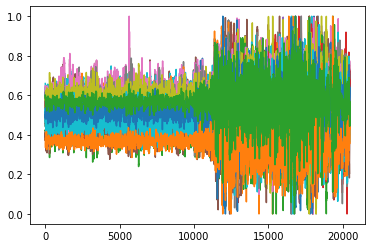

In [30]:
 plt.plot(df3)

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(df3)
df4 = scaler.fit_transform(df4)
df15 = scaler.fit_transform(df15)
df16 = scaler.fit_transform(df16)
df18 = scaler.fit_transform(df18)
df21 = scaler.fit_transform(df21)
df26 = scaler.fit_transform(df26)

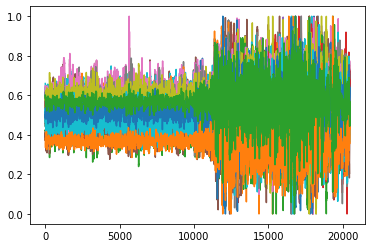

In [15]:
 plt.plot(df3)

In [31]:
print((df3.shape),(df4.shape),(df15.shape),(df16.shape),(df18.shape),(df21.shape),(df26.shape))

(20481, 23) (13825, 23) (20481, 23) (26113, 23) (46081, 23) (47617, 23) (51713, 23)


In [ ]:
past_history = 1279
forecast_horizon = 255

In [32]:
df3 = pd.DataFrame(df3).to_numpy()
df4 = pd.DataFrame(df4).to_numpy()
df15 = pd.DataFrame(df15).to_numpy()
df16 = pd.DataFrame(df16).to_numpy()
df18 = pd.DataFrame(df18).to_numpy()
df21 = pd.DataFrame(df21).to_numpy()
df26 = pd.DataFrame(df26).to_numpy()

In [33]:
def vectorized_stride(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        # Create a rightmost vector as [0, V, 2V, ...].
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    
    return array[sub_windows]

In [34]:
r3 = len(df3)-(len(df3)%1279)-1
r4 = len(df4)-(len(df4)%1279)-1
r15 = len(df15)-(len(df15)%1279)-1
r16 = len(df16)-(len(df16)%1279)-1
r18 = len(df18)-(len(df18)%1279)-1
r21 = len(df21)-(len(df21)%1279)-1
r26 = len(df26)-(len(df26)%1279)-1

In [35]:
df3_w = vectorized_stride(df3,1279,r3,1279,1279)
df4_w = vectorized_stride(df4,1279,r4,1279,1279)
df15_w = vectorized_stride(df15,1279,r15,1279,1279)
df16_w = vectorized_stride(df16,1279,r16,1279,1279)
df18_w = vectorized_stride(df18,1279,r18,1279,1279)
df21_w = vectorized_stride(df21,1279,47617-295,1279,1279)
df26_w = vectorized_stride(df26,1279,r26,1279,1279)

In [36]:
print(df3_w.shape,df4_w.shape, df16_w.shape, df15_w.shape, df18_w.shape, df21_w.shape, df26_w.shape)

(16, 1279, 23) (10, 1279, 23) (20, 1279, 23) (16, 1279, 23) (36, 1279, 23) (37, 1279, 23) (40, 1279, 23)


In [37]:
df3 = np.array(df3_w)
df4 = np.array(df4_w)
df15 = np.array(df15_w)
df16 = np.array(df16_w)
df18 = np.array(df18_w)
df21 = np.array(df21_w)
df26 = np.array(df26_w)

In [38]:
Train = np.vstack((df3 ,df4,df15 ,df16 ,df18 ,df21 ))
Test = (df26)

In [39]:
Train.shape

(135, 1279, 23)

In [40]:
Test.shape

(40, 1279, 23)

In [41]:
L3nsz = np.zeros((8,1))
L3sz = np.ones((8,1))
L3 = np.append(L3nsz,L3sz)

L4nsz = np.zeros((5,1))
L4sz = np.ones((5,1))
L4 = np.append(L4nsz,L4sz)

L15nsz = np.zeros((8,1))
L15sz = np.ones((8,1))
L15 = np.append(L15nsz,L15sz)

L16nsz = np.zeros((10,1))
L16sz = np.ones((10,1))
L16 = np.append(L16nsz,L16sz)

L18nsz = np.zeros((18,1))
L18sz = np.ones((18,1))
L18 = np.append(L18nsz,L18sz)

L21nsz = np.zeros((18,1))
L21sz = np.ones((19,1))
L21 = np.append(L21nsz,L21sz)

L26nsz = np.zeros((20,1))
L26sz = np.ones((20,1))
L26_test = np.append(L26nsz,L26sz)

In [42]:
Labels_Train = np.concatenate((L3,L4,L15,L16,L18,L21))
Labels_Test = L26_test

In [43]:
Labels_Train.shape

(135,)

In [44]:
Labels_Test.shape

(40,)

In [45]:
from tensorflow.keras import backend
from keras.utils import np_utils

In [46]:
nclases = 2
label_train_c = np_utils.to_categorical(Labels_Train,nclases)
label_test_c = np_utils.to_categorical(Labels_Test,nclases)

In [47]:
label_train_c.shape

(135, 2)

In [48]:
label_test_c.shape

(40, 2)

In [49]:
(x_train, y_train), (x_test, y_test) = ((Train,label_train_c),(Test,label_test_c))

In [50]:
print(x_train.shape)
print(x_test.shape)

(135, 1279, 23)
(40, 1279, 23)


In [74]:
past_history = 1279
forecast_horizon = 255

In [78]:
def show_plot(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-', c=colors(3), markersize=3.5)
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colors(0), markersize=3.5, label='True Future')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colors(2), markersize=3.5, label='Model prediction')
  ax.legend()

In [52]:
from collections import defaultdict
results = defaultdict(lambda: {})

In [94]:
lote = 2
epocas = 20

In [53]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Input

In [89]:
# Create model with one LSTM layer with 64 units
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64)(inp)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)

In [96]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1279, 23)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                22528     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 130       
Total params: 22,658
Trainable params: 22,658
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(x_train, y_train,
          batch_size=lote,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/20
68/68 [==============================] - 4s 40ms/step - loss: 0.4141 - val_loss: 0.5010
Epoch 2/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4199 - val_loss: 0.5405
Epoch 3/20
68/68 [==============================] - 2s 33ms/step - loss: 0.3640 - val_loss: 0.5036
Epoch 4/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4645 - val_loss: 0.4904
Epoch 5/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4603 - val_loss: 0.4839
Epoch 6/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4053 - val_loss: 0.4712
Epoch 7/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4698 - val_loss: 0.4614
Epoch 8/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4277 - val_loss: 0.5033
Epoch 9/20
68/68 [==============================] - 2s 33ms/step - loss: 0.4588 - val_loss: 0.4355
Epoch 10/20
68/68 [==============================] - 2s 33ms/step - loss: 0.3714 - val_loss: 0.4631
Epoch 11/

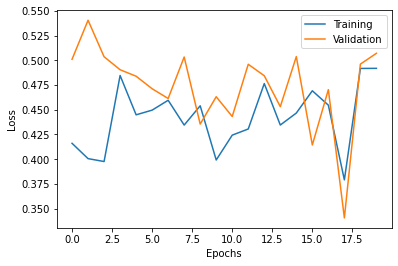

In [98]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

In [99]:
# predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['SimpleLSTM'] = mae
results['Y_PRED']['SimpleLSTM'] = predictions
pd.DataFrame(results)['MAE']

SimpleLSTM     5.330053
GRU            5.330053
TCN            1.516562
CNN            1.434608
MLP           66.993149
Name: MAE, dtype: float64

In [100]:
# GRU
inp = Input(shape=x_train.shape[-2:])
x = GRU(128, return_sequences=True)(inp)
x = GRU(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)


In [101]:

model.compile(optimizer='adam', loss='mae')
print(model.summary())


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1279, 23)]        0         
_________________________________________________________________
gru_12 (GRU)                 (None, 1279, 128)         58752     
_________________________________________________________________
gru_13 (GRU)                 (None, 1279, 64)          37248     
_________________________________________________________________
flatten_10 (Flatten)         (None, 81856)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                5238848   
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 130       
Total params: 5,334,978
Trainable params: 5,334,978
Non-trainable params: 0
________________________________________________

In [104]:
history = model.fit(x_train, y_train,
          batch_size=lote, # Cambio batch zize
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))


Epoch 1/20
68/68 [==============================] - 5s 75ms/step - loss: 0.5550 - val_loss: 0.8048
Epoch 2/20
68/68 [==============================] - 5s 73ms/step - loss: 0.6162 - val_loss: 0.4784
Epoch 3/20
68/68 [==============================] - 5s 73ms/step - loss: 0.8220 - val_loss: 0.5733
Epoch 4/20
68/68 [==============================] - 5s 73ms/step - loss: 0.4689 - val_loss: 0.4714
Epoch 5/20
68/68 [==============================] - 5s 74ms/step - loss: 0.3234 - val_loss: 0.4635
Epoch 6/20
68/68 [==============================] - 5s 74ms/step - loss: 0.3229 - val_loss: 0.5510
Epoch 7/20
68/68 [==============================] - 5s 74ms/step - loss: 0.3792 - val_loss: 0.5334
Epoch 8/20
68/68 [==============================] - 5s 74ms/step - loss: 0.3898 - val_loss: 0.4899
Epoch 9/20
68/68 [==============================] - 5s 74ms/step - loss: 0.2768 - val_loss: 0.4747
Epoch 10/20
68/68 [==============================] - 5s 73ms/step - loss: 0.2468 - val_loss: 0.4726
Epoch 11/

In [105]:
# TCN
inp = Input(shape=x_train.shape[-2:])
x = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8,16,32,64])(inp)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)


In [106]:

model.compile(optimizer='adam', loss='mae')
print(model.summary())


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1279, 23)]        0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 64)                168384    
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 130       
Total params: 168,514
Trainable params: 168,514
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 1.9153 - val_loss: 2.6382
Epoch 2/5
1/1 [==============================] - 0s 461ms/step - loss: 2.5357 - val_loss: 1.9721
Epoch 3/5
1/1 [==============================] - 0s 455ms/step - loss: 1.8777 - val_loss: 0.5665
Epoch 4/5
1/1 [==============================] - 0s 452ms/step - loss: 0.5602 - val_loss: 1.1132
Epoch 5/5
1/1 [==============================] - 0s 452ms/step - loss: 1.2122 - val_loss: 1.2472


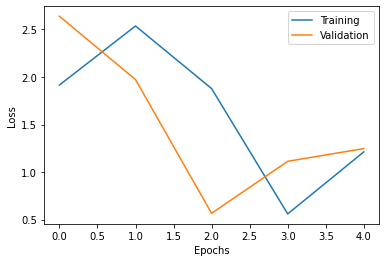

In [108]:

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

In [109]:

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['TCN'] = mae
results['Y_PRED']['TCN'] = predictions
print(pd.DataFrame(results)['MAE'])


SimpleLSTM     5.330053
GRU            5.330053
TCN            1.247160
CNN            1.434608
MLP           66.993149
Name: MAE, dtype: float64


In [ ]:

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

In [113]:
inp = Input(shape=x_train.shape[-2:])
x = Conv1D(128, 7, activation='relu', padding='same')(inp)
x = MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)


In [114]:
model.compile(optimizer='adam', loss='mae')
print(model.summary())


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1279, 23)]        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1279, 64)          7424      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 639, 64)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 40896)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 81794     
Total params: 89,218
Trainable params: 89,218
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
history = model.fit(x_train, y_train,
          batch_size=lote,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))


Epoch 1/20
68/68 [==============================] - 1s 5ms/step - loss: 1.0112 - val_loss: 0.4807
Epoch 2/20
68/68 [==============================] - 0s 3ms/step - loss: 0.4602 - val_loss: 0.4849
Epoch 3/20
68/68 [==============================] - 0s 3ms/step - loss: 0.4519 - val_loss: 0.4824
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.4501 - val_loss: 0.4493
Epoch 5/20
68/68 [==============================] - 0s 3ms/step - loss: 0.3781 - val_loss: 0.4181
Epoch 6/20
68/68 [==============================] - 0s 3ms/step - loss: 0.3467 - val_loss: 0.4946
Epoch 7/20
68/68 [==============================] - 0s 3ms/step - loss: 0.4086 - val_loss: 0.2912
Epoch 8/20
68/68 [==============================] - 0s 3ms/step - loss: 0.3056 - val_loss: 0.2996
Epoch 9/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2838 - val_loss: 0.3434
Epoch 10/20
68/68 [==============================] - 0s 3ms/step - loss: 0.2591 - val_loss: 0.2956
Epoch 11/20
68/68 [

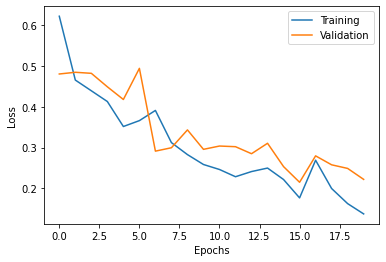

In [116]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])


In [117]:
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['CNN'] = mae
results['Y_PRED']['CNN'] = predictions
print(pd.DataFrame(results)['MAE'])


SimpleLSTM     5.330053
GRU            5.330053
TCN            1.247160
CNN            0.221832
MLP           66.993149
Name: MAE, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

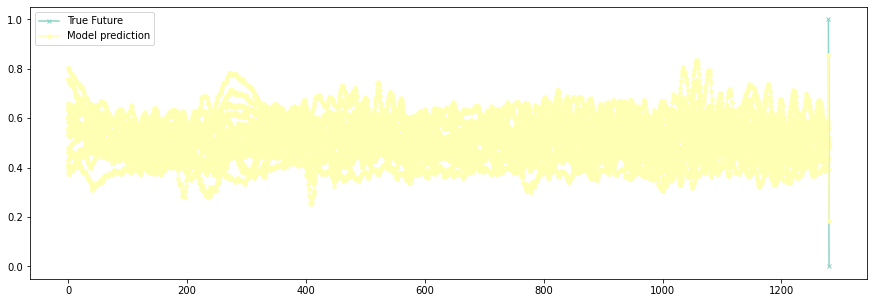

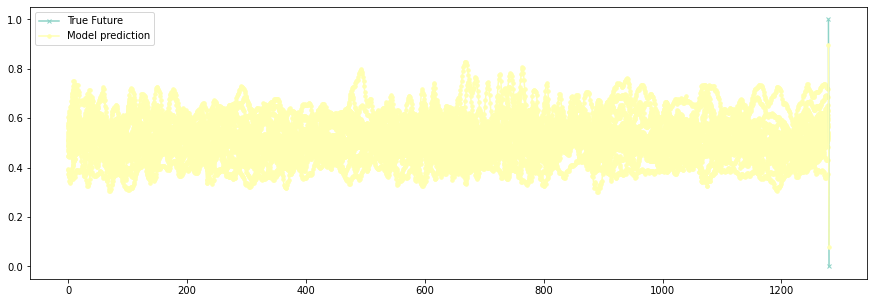

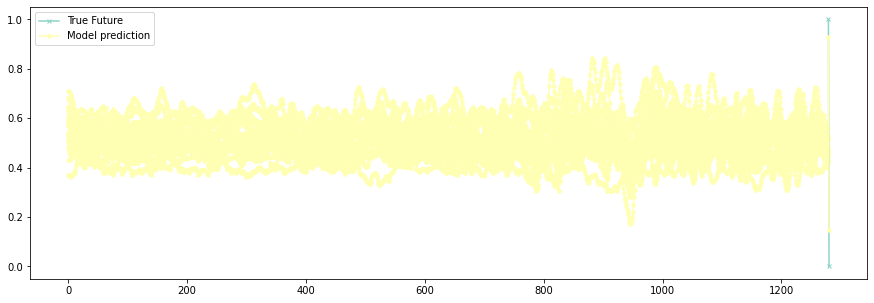

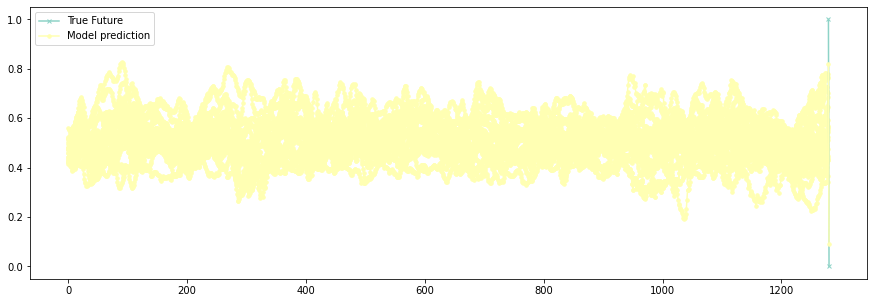

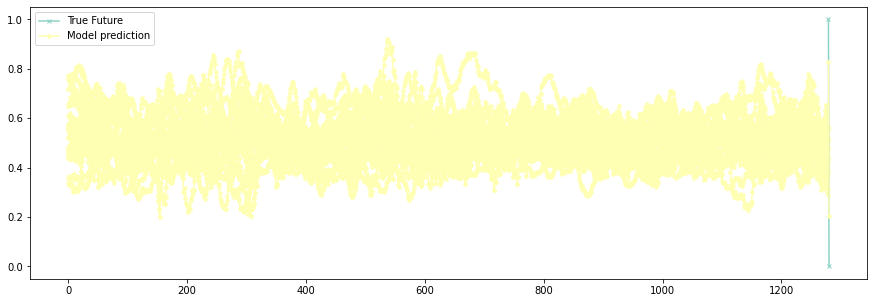

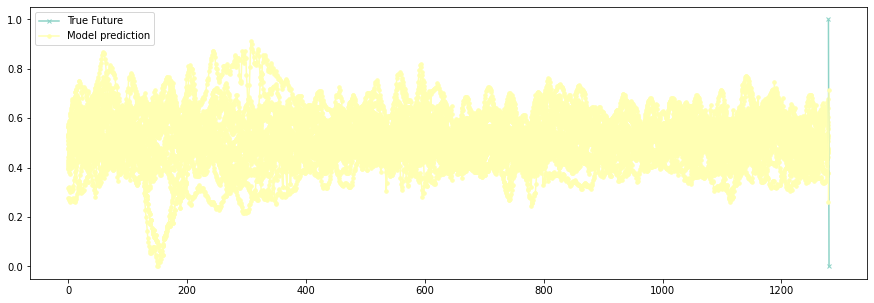

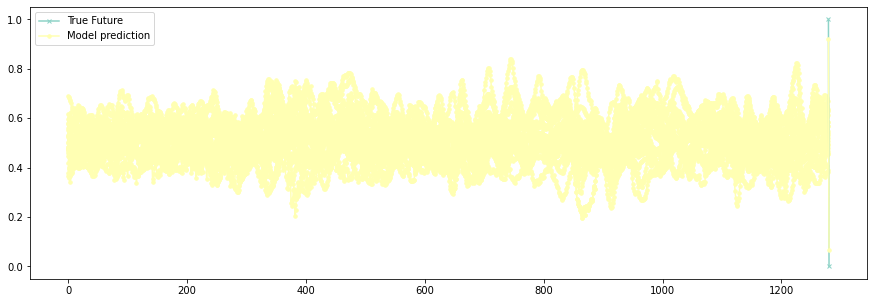

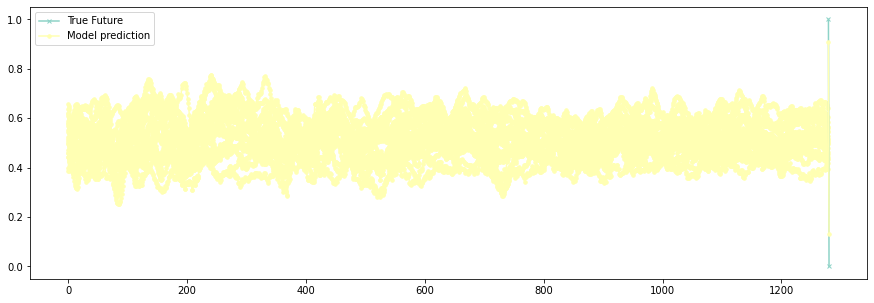

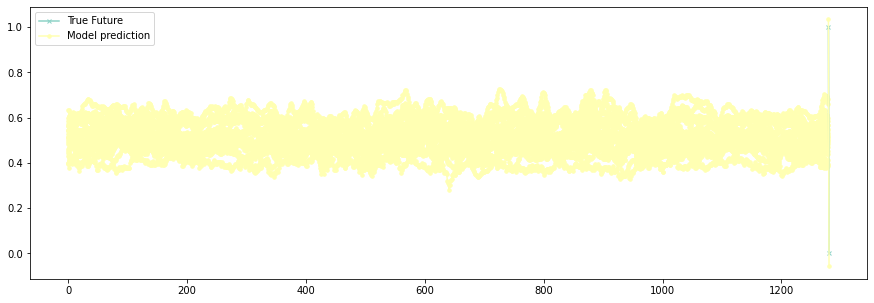

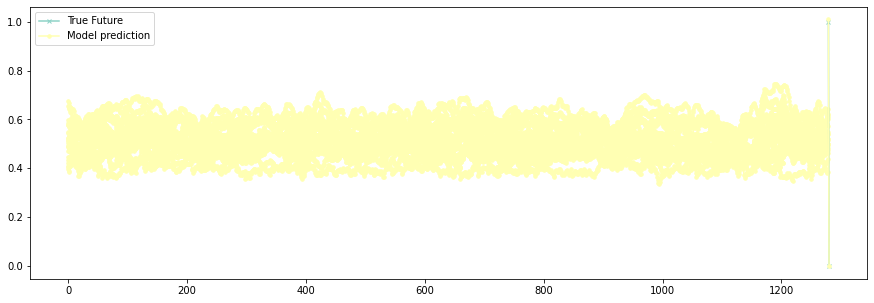

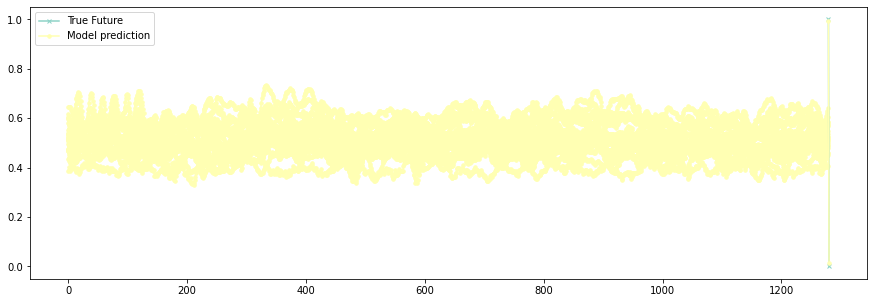

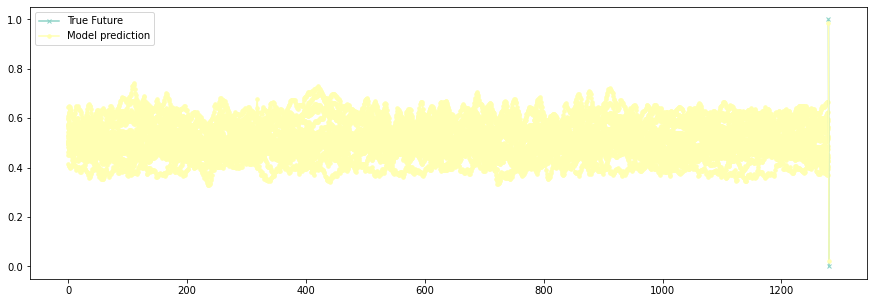

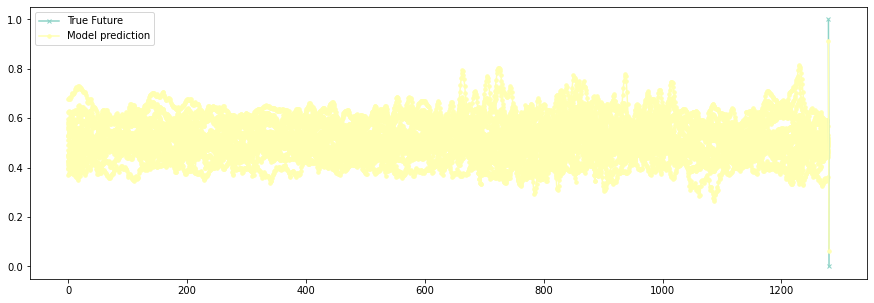

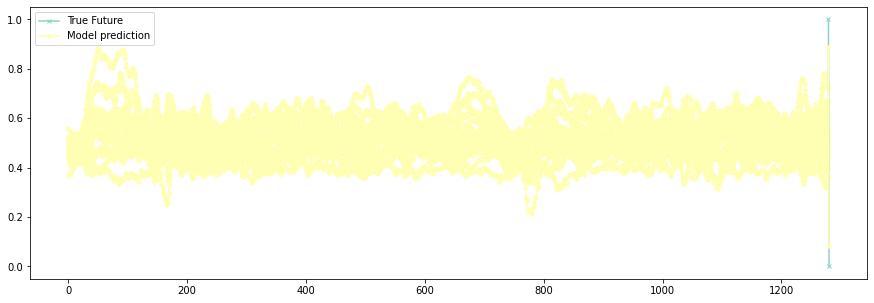

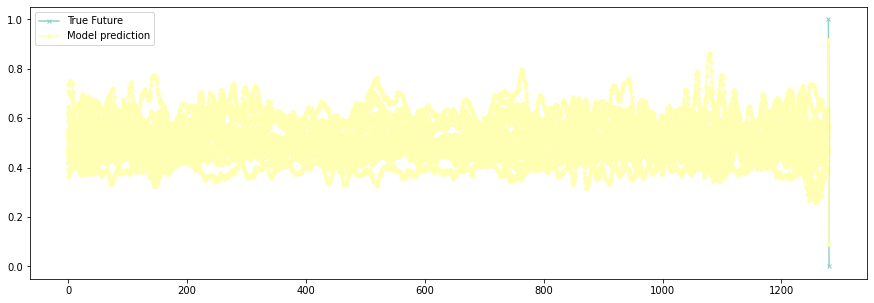

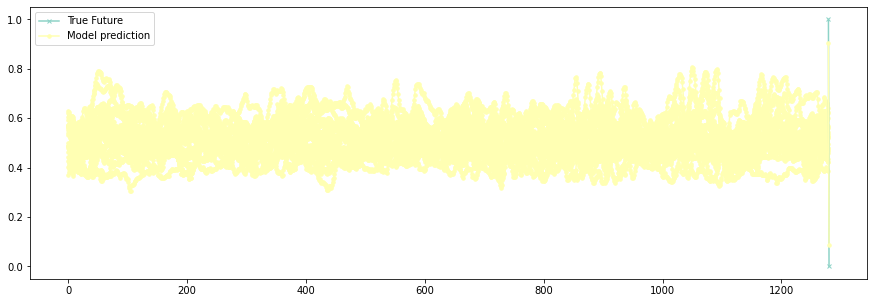

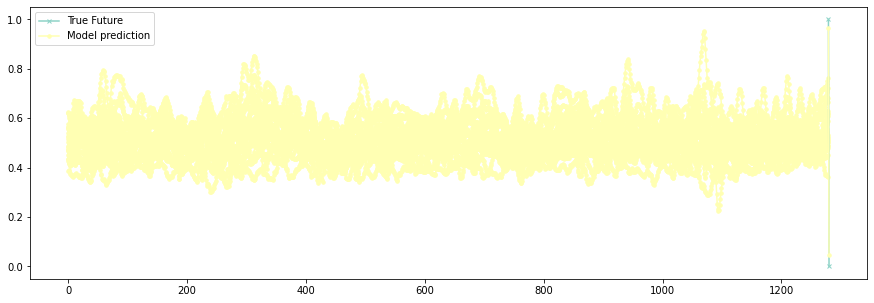

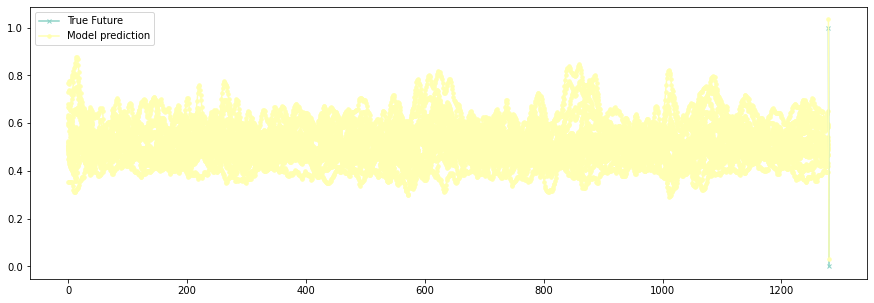

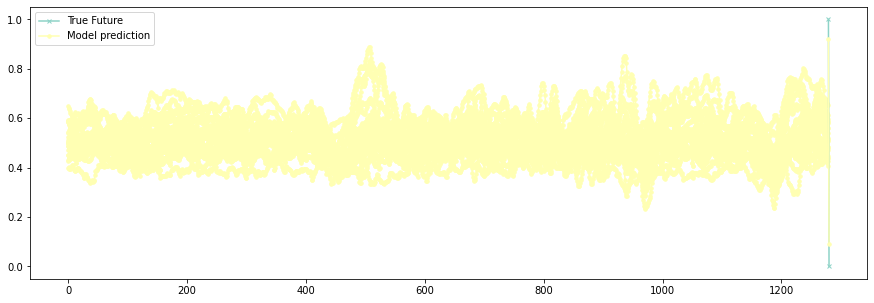

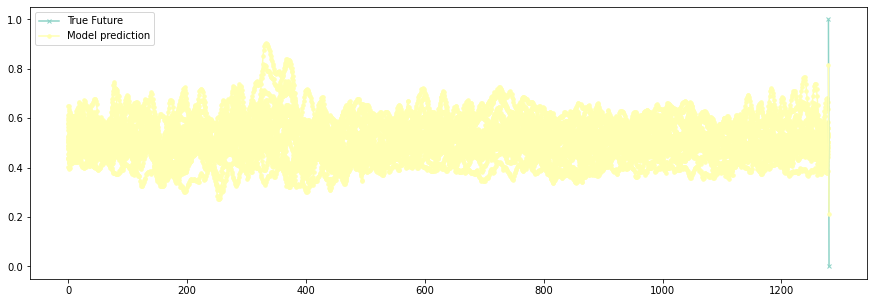

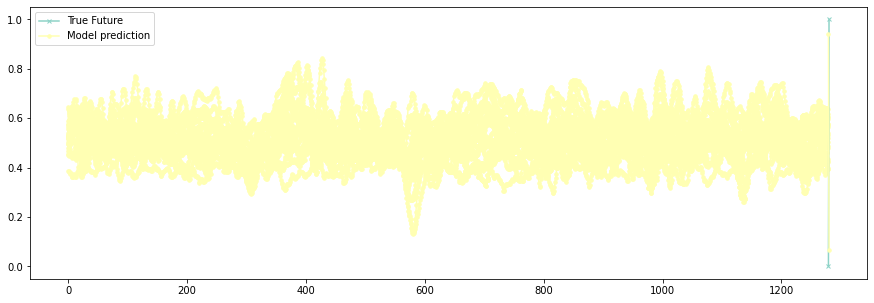

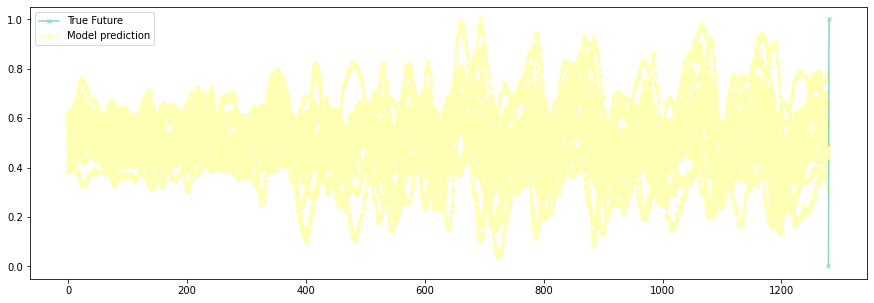

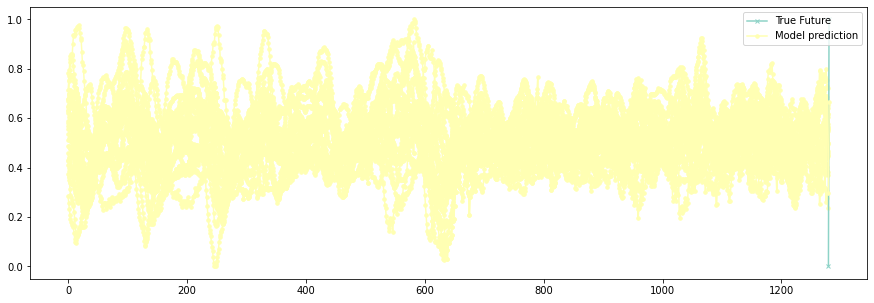

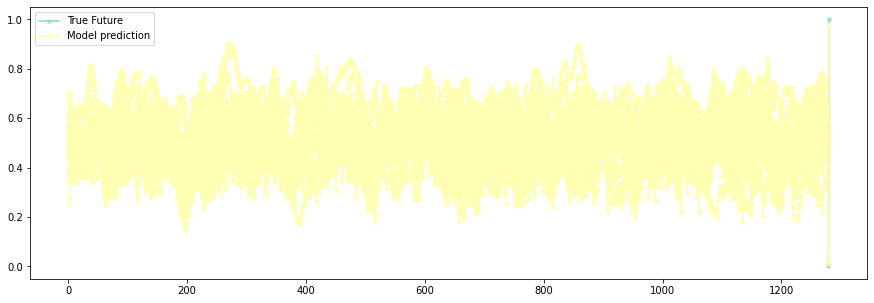

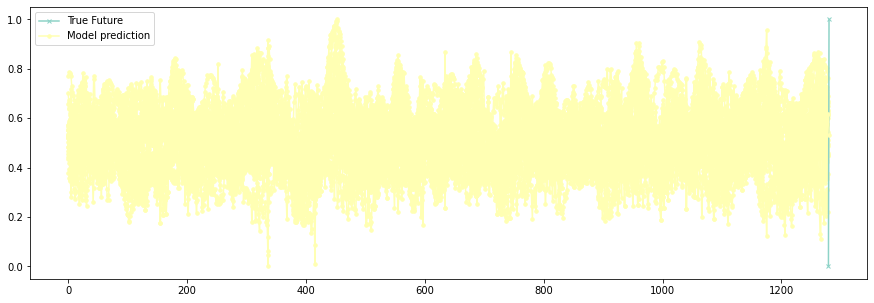

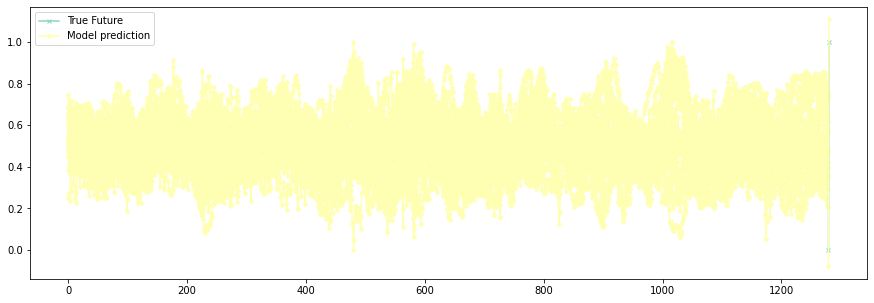

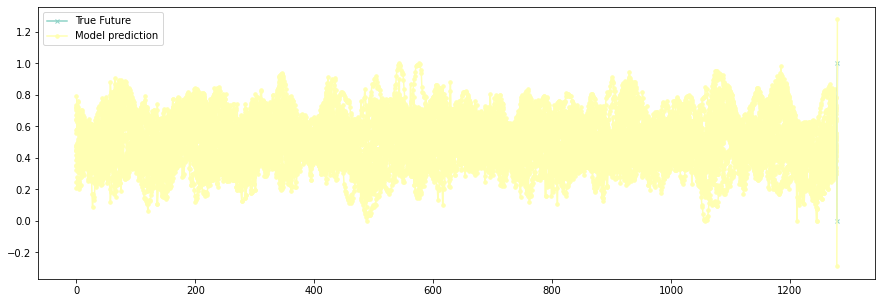

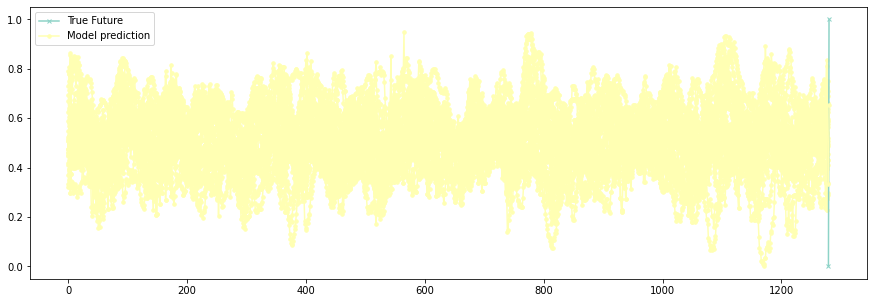

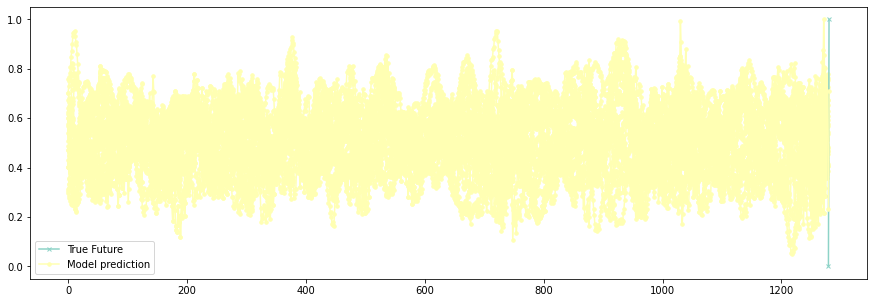

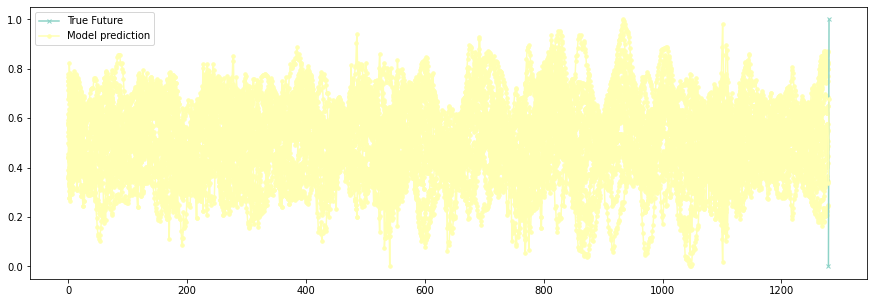

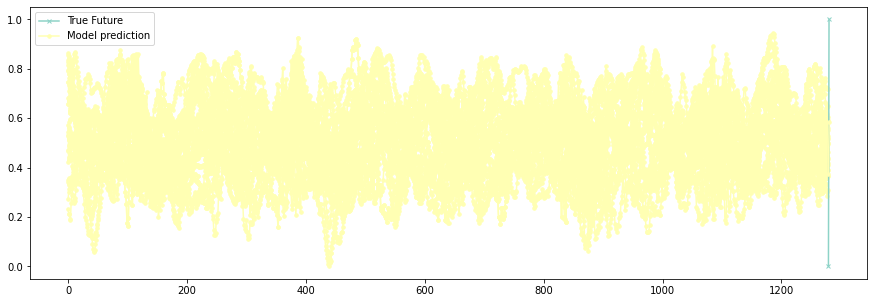

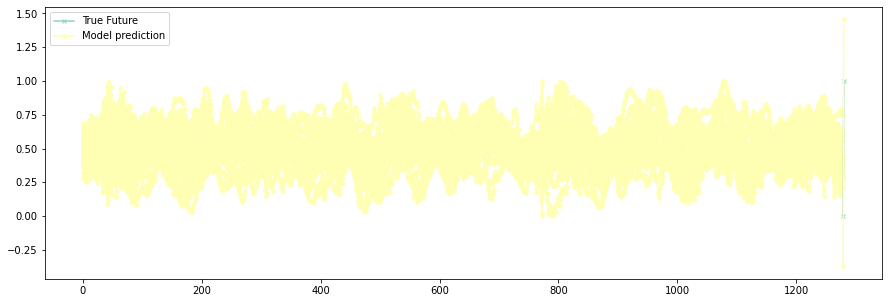

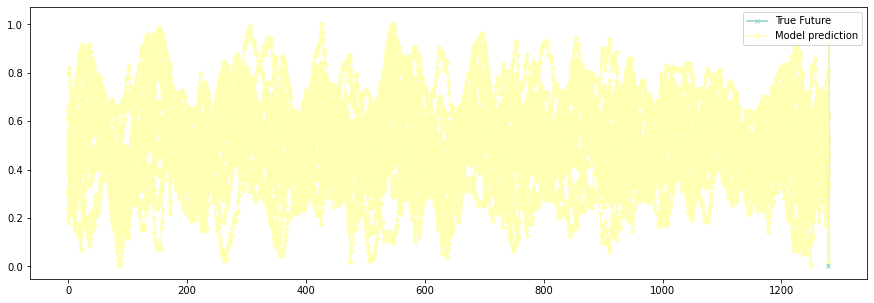

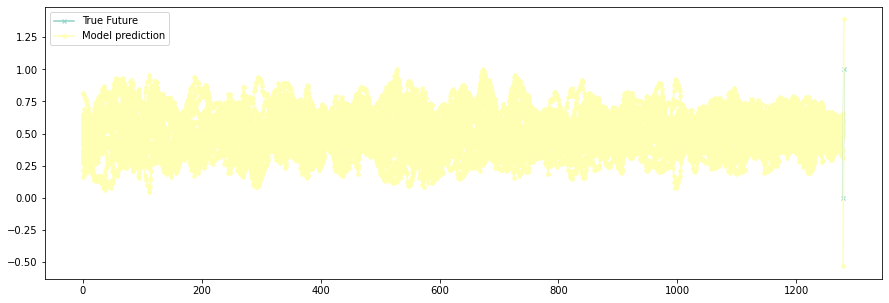

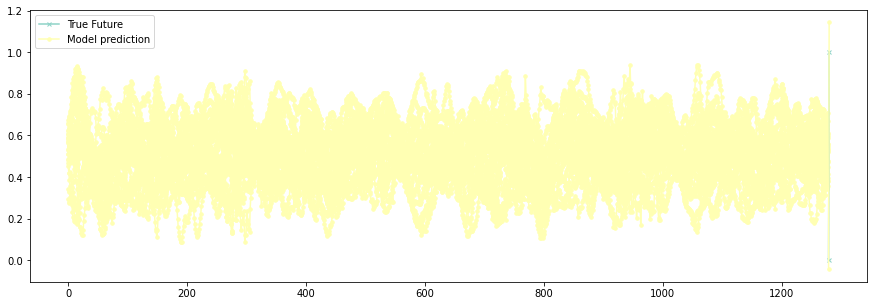

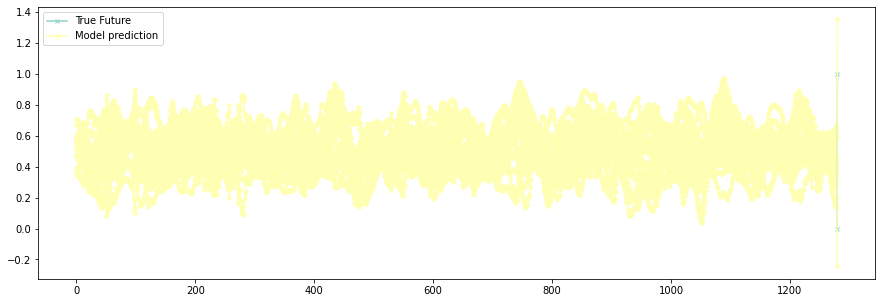

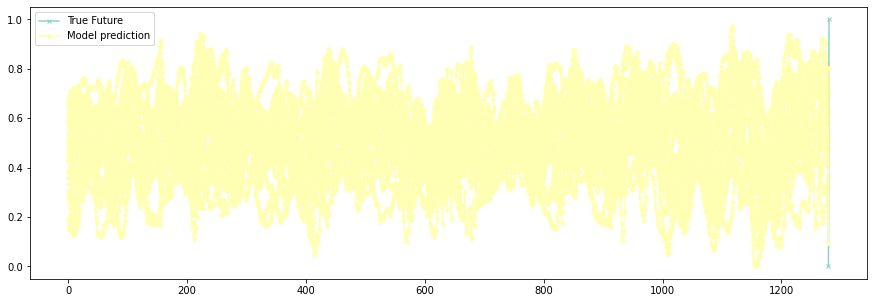

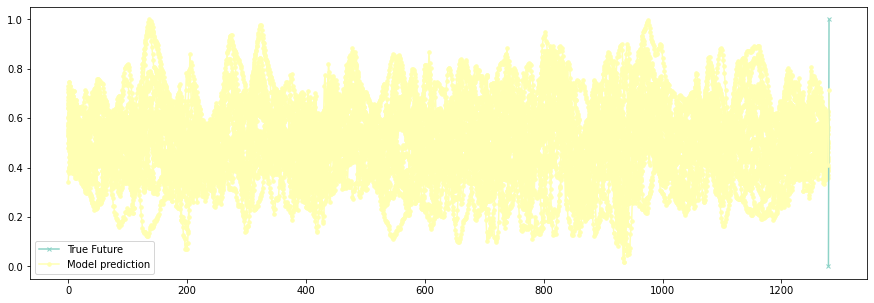

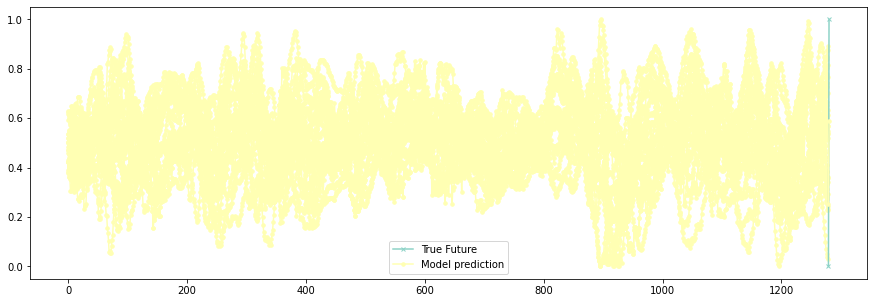

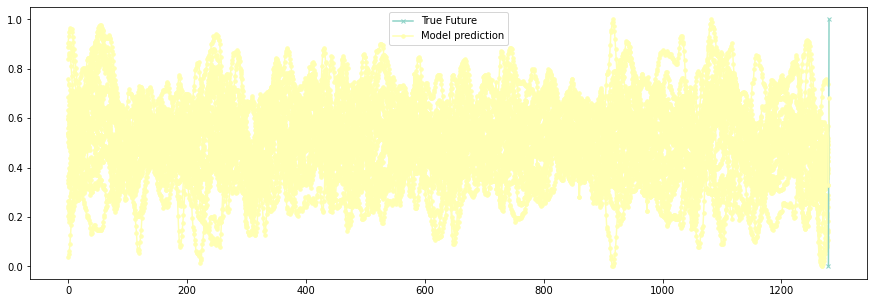

In [118]:

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

In [120]:
# MLP
inp = Input(shape=x_train.shape[-2:])
x = Flatten()(inp)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(2)(x)
model = keras.Model(inputs=inp, outputs=x)



In [121]:
model.compile(optimizer='adam', loss='mae')
print(model.summary())


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 1279, 23)]        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 29417)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               3765504   
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 66        
Total params: 3,775,906
Trainable params: 3,775,906
Non-trainable params: 0
________________________________________________

In [124]:

history = model.fit(x_train, y_train,
          batch_size=lote,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))


Epoch 1/20
68/68 [==============================] - 1s 8ms/step - loss: 0.8160 - val_loss: 1.6796
Epoch 2/20
68/68 [==============================] - 0s 3ms/step - loss: 0.9481 - val_loss: 0.5006
Epoch 3/20
68/68 [==============================] - 0s 4ms/step - loss: 0.6372 - val_loss: 0.6185
Epoch 4/20
68/68 [==============================] - 0s 3ms/step - loss: 0.5659 - val_loss: 0.6372
Epoch 5/20
68/68 [==============================] - 0s 3ms/step - loss: 0.7896 - val_loss: 0.9478
Epoch 6/20
68/68 [==============================] - 0s 3ms/step - loss: 0.8642 - val_loss: 0.5019
Epoch 7/20
68/68 [==============================] - 0s 3ms/step - loss: 0.5955 - val_loss: 0.7066
Epoch 8/20
68/68 [==============================] - 0s 4ms/step - loss: 0.7231 - val_loss: 0.9561
Epoch 9/20
68/68 [==============================] - 0s 3ms/step - loss: 0.5357 - val_loss: 0.6939
Epoch 10/20
68/68 [==============================] - 0s 3ms/step - loss: 0.7857 - val_loss: 0.5014
Epoch 11/20
68/68 [

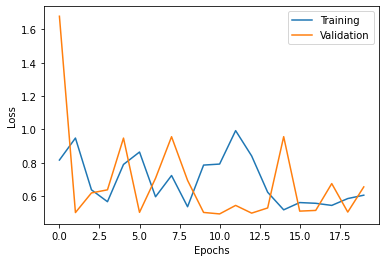

In [125]:

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])


In [126]:

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['MLP'] = mae
results['Y_PRED']['MLP'] = predictions
print(pd.DataFrame(results)['MAE'])

SimpleLSTM    5.330053
GRU           5.330053
TCN           1.247160
CNN           0.221832
MLP           0.654777
Name: MAE, dtype: float64


In [ ]:
for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

In [71]:
pd.DataFrame(results)['MAE']

SimpleLSTM     0.499472
GRU           13.005387
TCN            1.516562
CNN            1.434608
MLP           66.993149
Name: MAE, dtype: float64